In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math

def bbox_detection(src_img_copy, thresh, cimg):
    # noise removal
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)


    # sure background area
    sure_bg = cv2.dilate(opening,kernel,iterations=5)


    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_transform,0.01*dist_transform.max(),255,0)


    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)


    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)

    # Add one to all labels so that sure background is not 0, but 1
    # Markers: unknown--0, background--1, others--start from 2
    markers = markers+1

    # Now, mark the region of unknown with zero
    markers[unknown==255] = 0

    # Markers: Boundaries are marked as -1, background -- 1, others--start from 2
    markers = cv2.watershed(src_img_copy,markers)
    
    # Bounding box test
    markers_copy = markers.copy()
    markers_copy[markers_copy==-1] = 1
    markers_copy = np.array(markers_copy, dtype = np.uint8)

    num_iters = markers_copy.max() + 1

    bb_list = []
    for index in range(2, num_iters):
        thresh_img = np.zeros((HEIGHT, WIDTH), dtype = np.uint8)
        thresh_img[markers_copy==index] = 255
        im2, contours, hierarchy = cv2.findContours(thresh_img,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        # Draw bounding boxes
        idx =0 
        for cnt in contours:
            idx += 1
            x,y,w,h = cv2.boundingRect(cnt)
            # Check for qualified region proposals
            area = cv2.contourArea(cnt)
            if area > 2000 and area<20000:
                bb = cv2.boundingRect(cnt)
                bb_list.append(bb)
                cv2.rectangle(cimg,(x,y),(x+w,y+h),(255,255,0),2)
#                 cv2.rectangle(cimg,(1030,570),(1150,670),(64,117,0),5)
    return bb_list, cimg


[(1, 1, 83, 103), (440, 1, 34, 713), (1537, 1, 62, 303), (939, 531, 91, 100), (1258, 628, 77, 143), (1, 647, 55, 114), (418, 719, 101, 74), (823, 885, 69, 115), (1145, 919, 59, 120), (620, 1041, 129, 70)]


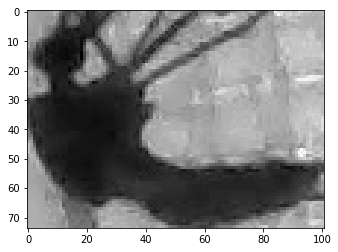

D:\Users\amrit\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
D:\Users\amrit\Anaconda3\lib\site-packages\numpy\core\_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [3]:
cap = cv2.VideoCapture('tracking_sample_video2.mp4')
ret, old_frame = cap.read()
ret, old_frame = cap.read()
ret, old_frame = cap.read()
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('test.mp4',fourcc, 20.0, (1600,1200))
IMG_upper_left_x = 0 
IMG_upper_left_y = 0
WIDTH = 1600
HEIGHT = 1200


img = old_frame[IMG_upper_left_x:IMG_upper_left_x + HEIGHT,IMG_upper_left_y:IMG_upper_left_y + WIDTH,:]
cimg = img.copy()  
src_img_copy = img.copy()
gray = cv2.cvtColor(src_img_copy,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,60,255,cv2.THRESH_BINARY_INV)

bb_list, cimg = bbox_detection(src_img_copy, thresh, cimg)
cv2.rectangle(cimg,(1030,570),(1150,670),(64,117,0),5)
cimg_s = cv2.resize(cimg,None,fx=0.5, fy=0.5, interpolation = cv2.INTER_CUBIC) 
# cv2.imshow('cimg_s', cimg_s)


if len(bb_list)>0:
    print(bb_list)
#     bb_list = [(1030,570,120,100)]
    index = 6


    old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
    p0, lk_params, color = get_tracking_features(old_gray, bb_list, index)

    while(1):
        ret,frame = cap.read()
        if ret==True:
            cimg = frame.copy()
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            if p0 is not None:
                p0, old_gray, cimg = tracking(p0, old_gray, frame_gray, lk_params, color, cimg)
            
            k = cv2.waitKey(30) & 0xff
            out.write(cimg)
            if k == 27:
                break
#             cv2.waitKey(-1)

        else:
            break

    cv2.destroyAllWindows()
    cap.release()
    out.release()

In [2]:
def get_tracking_features(old_gray, bb_list, index=0):  
    # params for ShiTomasi corner detection
    feature_params = dict( maxCorners = 100,
                           qualityLevel = 0.3,
                           minDistance = 7,
                           blockSize = 15 )

    # Parameters for lucas kanade optical flow
    lk_params = dict( winSize  = (15,15),
                      maxLevel = 4,
                      criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

    # Create some random colors
    color = np.random.randint(0,255,(100,3))

    # Take first frame and find corners in it

    tracking_feature_x, tracking_feature_y, tracking_feature_w, tracking_feature_h = bb_list[index]
    tracking_feature_roi = old_gray[tracking_feature_y:tracking_feature_y + tracking_feature_h,  
                                  tracking_feature_x:tracking_feature_x + tracking_feature_w]

    plt.imshow(tracking_feature_roi, 'gray')
    plt.show()
    p0 = cv2.goodFeaturesToTrack(tracking_feature_roi, mask = None, **feature_params)
    p0[:,:,0] += tracking_feature_x
    p0[:,:,1] += tracking_feature_y

    return p0, lk_params, color

def tracking(p0, old_gray, frame_gray, lk_params, color, cimg):
    # calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

    if p1 is not None:
        # Select good points
        good_new = p1[st==1]
        good_old = p0[st==1]

        # Create a mask image for drawing purposes
        mask = np.zeros_like(cimg)

        # draw the tracks
        for i,(new,old) in enumerate(zip(good_new,good_old)):
            a,b = new.ravel()
            c,d = old.ravel()
            mask = cv2.line(mask, (a,b),(c,d), color[i].tolist(), 2)
            cimg = cv2.circle(cimg,(a,b),5,color[i].tolist(),-1)
        features_mean = np.mean(good_new, axis=0)

        if not math.isnan(features_mean[0]):
            cv2.rectangle(cimg,(int(features_mean[0]-100),int(features_mean[1]-100)), \
                               (int(features_mean[0]+100),int(features_mean[1]+100)),(64,117,0),5)
        cimg = cv2.add(cimg,mask)
        cv2.imshow('frame',cimg)

        # Now update the previous frame and previous points
        old_gray = frame_gray.copy()
        p0 = good_new.reshape(-1,1,2)
    else:
        p0 = None
    
    return p0, old_gray, cimg